In [8]:
from ScriptFiles import DataCleaning_and_Prediction as dc
from ScriptFiles import DataRead_and_PreClean as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%inline matplotlib 


UsageError: Line magic function `%inline` not found.


In [9]:
#############################################################################
### Function to plot Data profile in terms of fuelvoltage, Distance over time

def plotData_profiles(df):
    plt.rcParams['figure.figsize'] = [16, 12]

    #### 1. Checking order of Data, as per datetime
    plt.subplot(3,1,1)
    plt.plot(df.index, df.datetime, 'g.', markersize=1, linewidth=1);

    plt.subplot(3,1,2)
    plt.plot(df.index, df.fuelVoltage, 'g.', markersize=2, linewidth=1);

    plt.subplot(3,1,3)
    plt.plot(df.index, df.distance, 'g-', markersize=2, linewidth=1);
    plt.title("Cumulative Distance vs Time", fontsize=15)
    plt.show()

In [46]:
#######################################################
### Function to Plot theft Points over Cleaned Data

def plot_theftpts(cleanedDf , theftpts = [], xlim=[], ylim = []):

    plt.rcParams['figure.figsize'] = [20, 4]
    # plt.subplot(6,1,1)
    plt.plot(cleanedDf.index, cleanedDf.fuelVoltage, 'g.', markersize=2, linewidth=1);
    plt.plot(cleanedDf.index, cleanedDf.distance, 'b-', markersize=2, linewidth=1);
    plt.title("Initial Prediction theft Points - ZOOMED")
    if len(xlim) !=0:
        plt.xlim(xlim)
    if len(ylim)!=0:
        plt.ylim(ylim)
    for pt in theftpts:
        plt.axvline(pt)
    plt.show()


In [51]:
def plot_Results(df, df_clean, result_df, xlim = [], ylim = []):

    plt.rcParams['figure.figsize']=[16,12]
    plt.subplot(4, 1, 1)
    plt.plot(df.datetime, df.fuelVoltage, 'g.', markersize=1, linewidth=1);
    plt.plot(df.datetime, df.distance, 'b-', markersize=1, linewidth=1);
    plt.title('Original FuelData vs Time')

    plt.subplot(4, 1, 2)
    plt.plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=1, linewidth=1);
    plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);
    plt.title('Cleaned Data')
    
    plt.subplot(4, 1, 3)
    plt.plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=1, linewidth=1);
    plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);
    plt.title('Final Predicted Theft Pts - ZOOMED')

    if len(xlim) !=0:
        plt.xlim(xlim)
    if len(ylim)!=0:
        plt.ylim(ylim)

    for pt in result_df.theft_index:
        plt.axvline(pt)

    plt.subplot(4, 1, 4)
    plt.plot(result_df.theft_index, result_df.fuel_jump, 'g-', markersize=3, linewidth=1);
    plt.title('Fuel/km Ratio at Predicted theft pts - ZOOMED')

#     if len(xlim) !=0:
#         plt.xlim(xlim)
#     if len(ylim)!=0:
#         plt.ylim(ylim)

    #plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);

    plt.show()

In [33]:
folderpath = r"G:\Analytics\FuelAnalysis\test2"
savePath = r"G:\Analytics\FuelAnalysis\results"
filepath = r""
df_list, filesname = dr.read__MultipleCSVs(folder_path= folderpath, nfiles=3)
ctr = 0
def formatDf(df):
    #df_list[0].info()
    Dmax = df.distance.max()
    df = dr.perform_PreFormating(df)
    print ("Dataset_"+str(ctr+1) +" Preformatting Done")

    dff = dr.perform_postFormating(df)
    print("Dataset_" + str(ctr + 1) + " Postformatting Done")
    return dff

def cleanDF(dff):
    df_clean = dc.Clean_NoiseData(dff, level= 6)
    print("Dataset_" + str(ctr + 1) + " Data Cleaning Done")
    return df_clean

def findtheft(df_clean):
    theft_pts = dc.theft_point(df_clean, level= 0.01)
    print("Dataset_" + str(ctr + 1) + " Theft points Indentified")
    return theft_pts

    

G:\Analytics\FuelAnalysis\test2\cordinates_007042639339.csv
G:\Analytics\FuelAnalysis\test2\cordinates_007042640749.csv
G:\Analytics\FuelAnalysis\test2\cordinates_007042641148.csv


In [34]:
#plotData_profiles(df)
df = df_list[0]
dff = formatDf(df)

Dataset_1 Preformatting Done
Dataset_1 Postformatting Done


In [39]:
df_clean = cleanDF(dff)

Dataset_2 Data Cleaning Done


In [40]:
theft_pts = findtheft(df_clean)

**
297
Dataset_2 Theft points Indentified


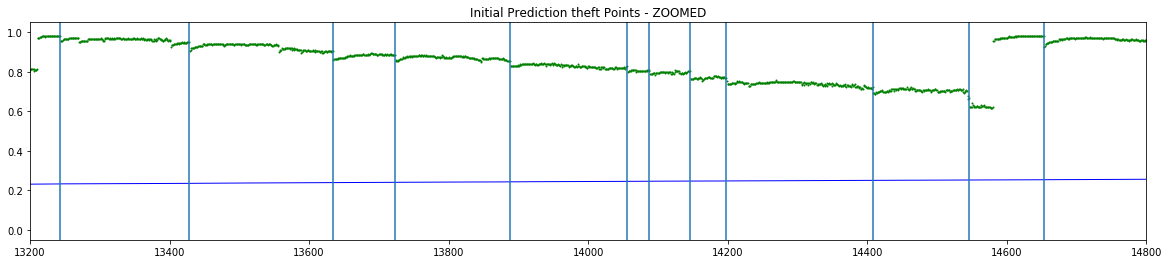

244


In [48]:
xlim = [13200,14800]
plot_theftpts(df_clean,theft_pts, xlim = xlim)
result_df = dc.generate_PredictTable(df_clean,theft_pts,Dmax)

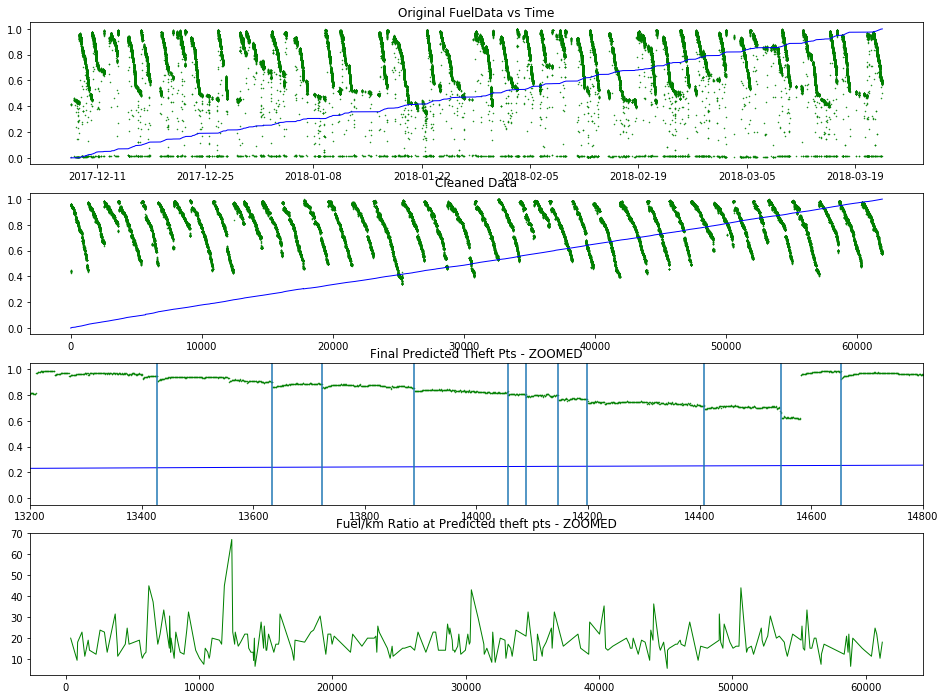

     theft_index        lat       long          theft_time  fuel_jump  dist_jump(KM)       time_jump  Possibility    FuelPerKM
0            368  22.378005  80.837357 2017-12-08 23:58:54  20.076482          8.201 0 days 00:33:46         True     2.448053
2            850  23.103885  79.027690 2017-12-09 12:47:58   9.560229          3.833 0 days 00:15:49         True     2.494190
3            892  23.346378  79.027083 2017-12-09 13:57:44  18.164436          7.521 0 days 02:17:16         True     2.415162
4           1217  24.955282  78.465725 2017-12-09 23:05:07  22.944551          3.049 0 days 06:28:07         True     7.525271
5           1429  25.967995  78.295802 2017-12-10 10:28:57  11.472275          4.633 0 days 00:50:16         True     2.476209
7           1683  26.834627  77.918940 2017-12-10 15:11:48  19.120459          6.161 0 days 01:02:35         True     3.103467
8           1782  27.163503  77.815312 2017-12-10 17:05:34  14.340344          2.450 0 days 00:22:11         Tr

In [52]:
#build_savePath = savePath + r"\result_dataset_" + filesname[ctr].replace(folderpath,"").replace('\\', "")
#result_df.to_csv(build_savePath)

plot_Results(dff,df_clean,result_df, xlim = xlim)
#ctr+=1
print(result_df)